In [7]:
import pandas as pd

summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv',
                      encoding='iso-8859-1')
raw = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv',
                  encoding='iso-8859-1')

In [8]:
#store the dataset in dataframe
pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'
        ].str.cat(pre2['read_more'].str.cat(pre2['text'
        ].str.cat(pre2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

#combining both the dataset
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']],
                           ignore_index=True)


In [9]:
pre.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


In [10]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):

    for row in column:
        
        # remove extra spaces
        row = re.sub("(\\t)", " ", str(row)).lower() 
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [11]:
processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])

In [12]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=500)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=500)]

In [13]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [14]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [15]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

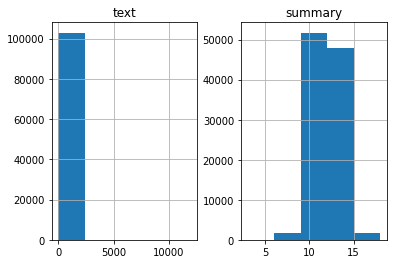

In [16]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [17]:
# Check how much % of text have 0-100 words
cnt = 0
for i in pre['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(pre['cleaned_text']))

0.9578389933440218


In [18]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 100
max_summary_len = 15

In [19]:
# Select the Summaries and Text which fall below max length 

import numpy as np

cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary= np.array(pre['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [20]:
# Add sostok and eostok

post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


In [21]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [22]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [23]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  62.625791318822664


In [24]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 29638


In [25]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 62.55667945587723
Size of vocabulary in Y = 12883


In [26]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens 
#train data
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [27]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
#test data
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

2022-12-01 21:04:50.463605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 21:04:50.464739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 21:04:50.465391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 21:04:50.466211: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     5927600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [31]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=1024,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50


2022-12-01 21:04:59.298542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


87/87 [==============================] - 141s 2s/step - loss: 5.8580 - accuracy: 0.2478 - val_loss: 5.2433 - val_accuracy: 0.3529
Epoch 2/50
87/87 [==============================] - 131s 2s/step - loss: 5.1421 - accuracy: 0.3578 - val_loss: 4.9762 - val_accuracy: 0.3662
Epoch 3/50
87/87 [==============================] - 132s 2s/step - loss: 4.9945 - accuracy: 0.3621 - val_loss: 4.8997 - val_accuracy: 0.3693
Epoch 4/50
87/87 [==============================] - 132s 2s/step - loss: 4.8953 - accuracy: 0.3665 - val_loss: 4.7901 - val_accuracy: 0.3739
Epoch 5/50
87/87 [==============================] - 131s 2s/step - loss: 4.7567 - accuracy: 0.3722 - val_loss: 4.6697 - val_accuracy: 0.3796
Epoch 6/50
87/87 [==============================] - 131s 2s/step - loss: 4.6142 - accuracy: 0.3786 - val_loss: 4.5464 - val_accuracy: 0.3847
Epoch 7/50
87/87 [==============================] - 131s 2s/step - loss: 4.4879 - accuracy: 0.3845 - val_loss: 4.4569 - val_accuracy: 0.3898
Epoch 8/50
87/87 [======

In [32]:

model.save('Text_Summarizer.h5')
print('Model Saved!')

Model Saved!


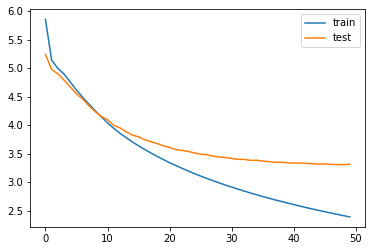

In [33]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [35]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [37]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [39]:
for i in range(0, 19):
    print ('Review:', seq2text(x_val[i]))
    print ('Predicted summary:', decode_sequence(x_val[i].reshape(1,
           max_text_len)))
    print('\n')

Review: after the valuation of electric carmaker tesla hit an all time high on monday the company billionaire ceo elon musk took dig at short sellers or people who bet against its stock by tweeting stormy weather in he added tesla is if based on the past but that irrelevant stock price represents risk adjusted future cash flows 
Predicted summary:  start tesla hires musk to make tesla car stock after musk exit end


Review: the principal of government school in uttar pradesh has been getting facial within school premises during school hours on being asked why she was getting facial the principal said she had free time however she later claimed she was getting the windows fixed and alleged that she was being framed because another woman wanted her post 
Predicted summary:  start class 12 girls to get up school school in up end


Review: the delhi government announced it would roll out scheme within three to four months wherein 40 public services including driving licences and caste cert

In [41]:
d = {"text": [], "actual": [], "predict": [], "similarity": []}

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def COSINE(base_document,document):
    content = [base_document, document]
    cv = CountVectorizer()
    count_matrix = cv.fit_transform(content)

    from sklearn.metrics.pairwise import cosine_similarity
    mat = cosine_similarity(count_matrix)
    return mat[1][0]*100

In [44]:
#d = {"text": [], "actual": [], "predict": [], "similarity": []}
for i in range(0, 19):
    print ('Review:', seq2text(x_tr[i]))
    d['text'].append(seq2text(x_tr[i]))
    d['actual'].append(seq2summary(y_tr[i]))
    str=decode_sequence(x_tr[i].reshape(1,max_text_len))
    print ('Predicted summary:',str)
    d['predict'].append(str)
    d['similarity'].append(COSINE(seq2summary(y_tr[i]),str))
    print('\n')

Review: lok janshakti party president ram vilas paswan daughter asha has said she will contest elections against him from constituency if given ticket from lalu prasad yadav rjd she accused him of neglecting her and promoting his son chirag asha is paswan daughter from his first wife while chirag is his son from his second wife 
Predicted summary:  start will attend ram nath kovind to contest 2019 polls end


Review: irish deputy prime minister frances fitzgerald announced her resignation on tuesday in bid to avoid the collapse of the government and potential snap election she quit hours before no confidence motion was to be proposed against her by the main opposition party the political crisis began over fitzgerald role in police whistleblower scandal 
Predicted summary:  start french prez resigns amid corruption charges end


Review: rr wicketkeeper batsman jos buttler slammed his fifth straight fifty in ipl 2018 on sunday to equal former indian cricketer virender sehwag record of mo

In [45]:
new = pd.DataFrame.from_dict(d)

In [46]:
new

,text,actual,predict,similarity
0,lok janshakti party president ram vilas paswan...,start will contest against father ram vilas fr...,start will attend ram nath kovind to contest ...,47.673129
1,irish deputy prime minister frances fitzgerald...,start irish deputy prime minister resigns to a...,start french prez resigns amid corruption cha...,31.980107
2,rr wicketkeeper batsman jos buttler slammed hi...,start buttler equals sehwag record of most str...,start rcb captain slams kohli for most ipl 50...,38.575837
3,the enforcement directorate ed has attached as...,start enforcement attached assets worth ã¢ââ¹...,start ed attaches assets worth ã¢ââ¹1 crore ...,45.454545
4,maruti suzuki india on wednesday said it is re...,start maruti recalls its mini trucks over fuel...,start maruti suzuki recalls 1 cars in india end,58.834841
5,the arrested lashkar e taiba let terrorist aam...,start pak helped me enter india arrested let t...,start j youth mastermind arrested for terrori...,43.643578
6,sunny leone has shared post on instagram in wh...,start sunny asks fans to help staff member bat...,start fb apologises for shaming who wrote hom...,16.012815
7,andhra pradesh chief minister chandrababu naid...,start most backward classes to get 100 units f...,start andhra cm announces ã¢ââ¹1 000 crore t...,46.153846
8,us president donald trump on wednesday said th...,start n korea has returned remains of 200 us w...,start us prez trump kim jong un is the bigges...,38.575837
9,four witnesses in the pehlu khan lynching case...,start khan lynching witnesses sons shot at on ...,start 3 year old killed in encounter in gujar...,17.407766


In [48]:
print("Accuracy:",sum(d['similarity'])/len(d['similarity']))

Accuracy: 38.146425329122586
